In [1]:
from processing.process_raw_data import *

In [2]:
import anndata
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import matplotlib as mpl 
mpl.rcParams['figure.figsize'] = 6,6

In [3]:
anndata.__version__

<Version('0.7.1')>

In [4]:
mda = '/wynton/scratch/bp205/processed/MDA_lognorm_adata.h5ad'

In [5]:
adata = sc.read_h5ad(mda)
adata.obs['logqual']=np.log10(adata.obs.quality)
adata = adata[adata.obs.logqual >= 1, :]

In [6]:
adata = adata[adata.obs.logqual >= 1, :]

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [7]:
sc.tl.pca(adata, svd_solver='arpack')

In [8]:
adata

AnnData object with n_obs × n_vars = 6702 × 19603 
    obs: 'SampleType', 'quality', 'n_genes', 'percent_mito', 'n_counts', 'logqual'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine.

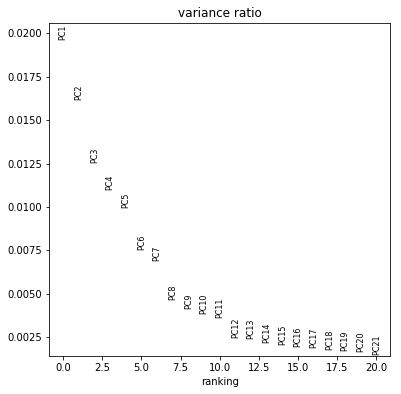

In [9]:
sc.pl.pca_variance_ratio(adata, log=False,n_pcs = 20)

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [10]:
sc.pp.neighbors(adata, n_neighbors=15, knn = True, n_pcs=12)

## Embedding the neighborhood graph

We advertise embedding the graph in 2 dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is  potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preservers trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```

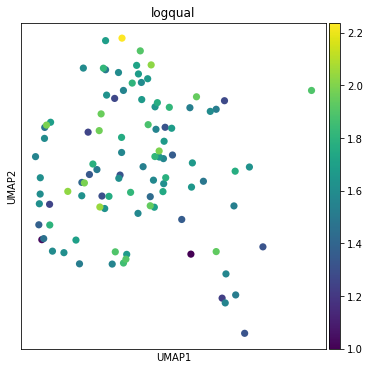

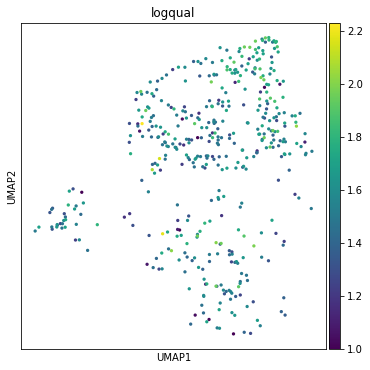

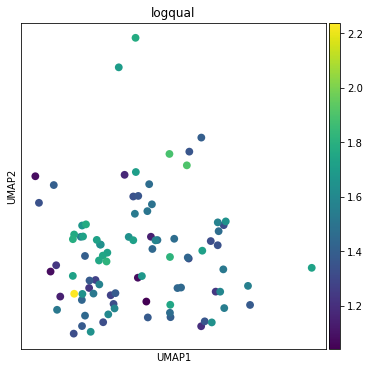

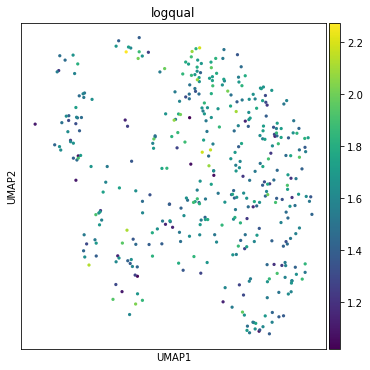

In [11]:
sc.tl.umap(adata)

adata_LM2 = adata[adata.obs.SampleType == 'LM2', :]
sc.pl.umap(adata_LM2, color=['logqual'])

adata_BoM = adata[adata.obs.SampleType == 'BoM', :]
sc.pl.umap(adata_BoM, color=['logqual'])

adata_Brm2 = adata[adata.obs.SampleType == 'Brm2', :]
sc.pl.umap(adata_Brm2, color=['logqual'])

adata_TGL = adata[adata.obs.SampleType == 'TGL', :]
sc.pl.umap(adata_TGL, color=['logqual'])

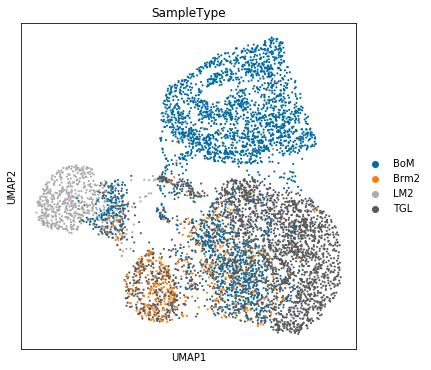

In [12]:
sc.pl.umap(adata, color=['SampleType'], save = 'origin-cluster.svg')

In [13]:
LM2_percent = []
BoM_percent = []
Brm2_percent = []
Parental_percent = []
mask = []
mask_three = []

for i in range(0, len(adata)):
    if adata.obs.iloc[i]['SampleType'] == 'LM2':
        mask.append('LM2')
    elif adata.obs.iloc[i]['SampleType'] == 'BoM':
        mask.append('BoM')
    elif adata.obs.iloc[i]['SampleType'] == 'Brm2':
        mask.append('Brm2')
    else:
        neighbours = adata.obs[adata.uns['neighbors']['distances'].toarray()[i] != 0]
        num_LM2 = len(neighbours[neighbours['SampleType'] == 'LM2'])
        num_BoM = len(neighbours[neighbours['SampleType'] == 'BoM'])
        num_Brm2 = len(neighbours[neighbours['SampleType'] == 'Brm2'])
        if num_LM2/14.0 >= 0.5:
            mask.append('p-LM2')
        elif num_BoM/14.0 >= 0.5:
            mask.append('p-BoM')
        elif num_Brm2/14.0 >= 0.5:
            mask.append('p-Brm2')
        else:
            mask.append('p-Low')

... storing 'status' as categorical


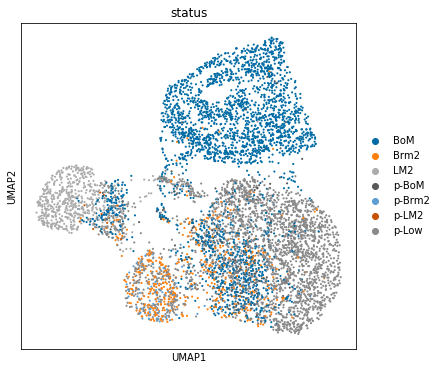

In [15]:
adata.obs['status'] = mask
sc.pl.umap(adata, color=['status'])

In [16]:
sc.tl.leiden(adata)

In [17]:
a = adata.obs.groupby(by = ['leiden', 'SampleType']).size() / adata.obs.groupby(by = 'leiden').size()
iter = 0
cluster = 0 
dicty = dict.fromkeys(range(0,17))
while iter <= 55:
    if (str(cluster), 'TGL') in a.index:
        dicty[cluster] = a.loc[str(cluster), 'TGL']
    cluster += 1
    iter += 3
dicty.pop(14)

In [18]:
sorted_clusters = [14, 4, 12, 5, 6, 7, 9, 15, 0, 10, 16, 13, 2, 8, 3, 11, 1]

In [19]:
names = dict.fromkeys(sorted_clusters)
for key in names.keys():
    names[key] = sorted_clusters.index(key)
     

In [20]:
names

{14: 0,
 4: 1,
 12: 2,
 5: 3,
 6: 4,
 7: 5,
 9: 6,
 15: 7,
 0: 8,
 10: 9,
 16: 10,
 13: 11,
 2: 12,
 8: 13,
 3: 14,
 11: 15,
 1: 16}

In [21]:
adata.obs['sorted_leiden'] = ''
for row in range(len(adata.obs['leiden'])):
    adata.obs['sorted_leiden'][row] = names[int(adata.obs['leiden'][row])]

/wynton/home/pollard/egilbertson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


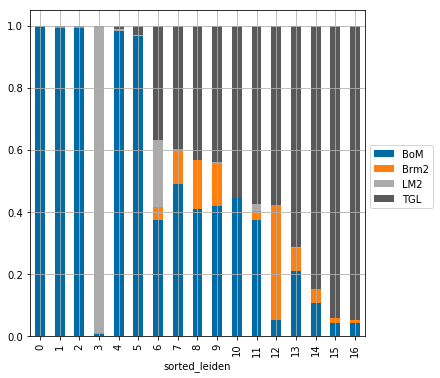

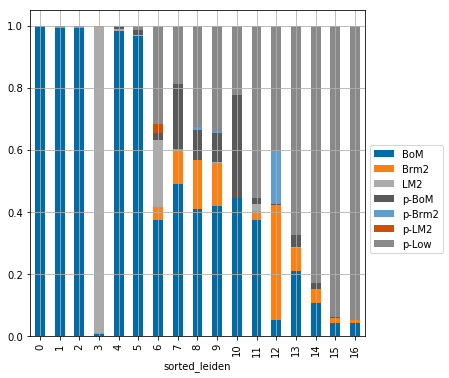

In [22]:
x = adata.obs.groupby(by = ['sorted_leiden', 'SampleType']).size() / adata.obs.groupby(by = 'sorted_leiden').size()
ax = x.unstack().plot(kind='bar', stacked = True)
ax.legend(bbox_to_anchor=(1, .6))
ax.grid(b=None)

#plt.savefig('MDA_box.svg', format = 'svg')


x = adata.obs.groupby(by = ['sorted_leiden', 'status']).size() / adata.obs.groupby(by = 'sorted_leiden').size()
ax = x.unstack().plot(kind='bar', stacked = True)
ax.legend(bbox_to_anchor=(1, .6))
ax.grid(b=None)

... storing 'sorted_leiden' as categorical


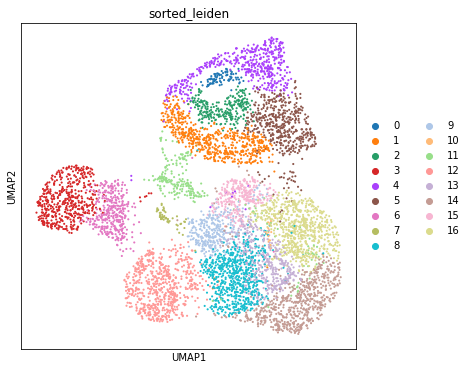

In [23]:
sc.pl.umap(adata, color=['sorted_leiden']) # , save = 'leiden-cluster.svg'
#sc.pl.umap(adata, color=['SampleType','status'])


In [29]:
def DE_pairwise(adata, column,group, refer):
    plt.figure(figsize = (5,5))
    sc.tl.rank_genes_groups(adata, column, groups=[group], reference=refer, method='wilcoxon',n_genes = len(adata.var))
    fold_change = adata.uns['rank_genes_groups']['logfoldchanges'][group]
    gene_list = adata.uns['rank_genes_groups']['names'][group]
    pvals = adata.uns['rank_genes_groups']['pvals'][group]
    df1=pd.DataFrame(list(zip(gene_list,fold_change,pvals)),columns = ['genes','logfoldchange','pvals'])
    df1 = df1[df1.pvals<0.05]
    df1= df1.sort_values('logfoldchange',ascending=False)
    df1.index = range(len(df1))
    result = pd.DataFrame()
    for i in range(len(df1)):
        x = df1['logfoldchange'][i]
        y = - np.log10(df1.pvals)[i]
        result = result.append(df1.iloc[i][:])
        if x > 1 or x < -1:
            plt.scatter(x, y, marker='x', color='red')
            if x>=4 or x <=-4:
                plt.text(x, y+0.2, df1.genes[i], fontsize=9)
        else:
            plt.scatter(x, y,color = 'black',alpha = 0.5,s= 6)        
    plt.xlabel('log2 fold change')
    plt.ylabel('-log10(p value)')
    plt.title(group + ' vs '+ refer)
    plt.savefig('/wynton/home/pollard/egilbertson/SystemsClass/SystemsProject/BP205B_2020/figures/'+group+'_vs_'+refer + '.svg', format = 'svg')
    result.to_csv('/wynton/home/pollard/egilbertson/SystemsClass/SystemsProject/BP205B_2020/DE_results/'+group+'_vs_'+refer+'.csv')
    
    
    
def DE_rest(adata,column):
    print(set(adata.obs[column]))
    sc.tl.rank_genes_groups(adata, column, method='wilcoxon',n_genes = len(adata.var))
    for group in set(adata.obs[column]):
        plt.figure(figsize = (5,5))
        fold_change = adata.uns['rank_genes_groups']['logfoldchanges'][group]
        gene_list = adata.uns['rank_genes_groups']['names'][group]
        pvals = adata.uns['rank_genes_groups']['pvals'][group]
        df1=pd.DataFrame(list(zip(gene_list,fold_change,pvals)),columns = ['genes','logfoldchange','pvals'])
        df1 = df1[df1.pvals<0.05]
        df1= df1.sort_values('logfoldchange',ascending=False)
        df1.index = range(len(df1))
        result = pd.DataFrame()
        for i in range(len(df1)):
            x = df1['logfoldchange'][i]
            y = - np.log10(df1.pvals)[i]
            result = result.append(df1.iloc[i][:])
            if x > 1 or x < -1:
                plt.scatter(x, y, marker='x', color='red')
                if x>=4 or x <=-4:
                    plt.text(x, y+0.2, df1.genes[i], fontsize=9)
            else:
                plt.scatter(x, y,color = 'black',alpha = 0.5,s= 6)        
        plt.xlabel('log2 fold change')
        plt.ylabel('-log10(p value)')
        plt.title(group + ' vs rest')
        #plt.savefig('/wynton/home/pollard/egilbertson/SystemsClass/SystemsProject/BP205B_2020/figures'+group+'_vs_rest', format = 'svg')
        #result.to_csv('/wynton/home/pollard/egilbertson/SystemsClass/SystemsProject/BP205B_2020/DE_results/'+group+'_vs_rest.csv')
        
        
        
        
        
        
def DE_rest_individual(adata,column, group, fn):
    sc.tl.rank_genes_groups(adata, column, method='wilcoxon',n_genes = len(adata.var))
    plt.figure(figsize = (5,5))
    fold_change = adata.uns['rank_genes_groups']['logfoldchanges'][group]
    gene_list = adata.uns['rank_genes_groups']['names'][group]
    pvals = adata.uns['rank_genes_groups']['pvals'][group]
    df1=pd.DataFrame(list(zip(gene_list,fold_change,pvals)),columns = ['genes','logfoldchange','pvals'])
    df1 = df1[df1.pvals<0.05]
    df1= df1.sort_values('logfoldchange',ascending=False)
    df1.index = range(len(df1))
    result = pd.DataFrame()
    for i in range(len(df1)):
        x = df1['logfoldchange'][i]
        y = - np.log10(df1.pvals)[i]
        result = result.append(df1.iloc[i][:])
        if x > 1 or x < -1:
            plt.scatter(x, y, marker='x', color='red')
            if x>=4 or x <=-4:
                plt.text(x, y+0.2, df1.genes[i], fontsize=9)
        else:
            plt.scatter(x, y,color = 'black',alpha = 0.5,s= 6)        
    plt.xlabel('log2 fold change')
    plt.ylabel('-log10(p value)')
    plt.title(fn + ' vs rest')
    #plt.savefig('/wynton/home/pollard/egilbertson/SystemsClass/SystemsProject/BP205B_2020/figures/'+fn+'_vs_rest.svg', format = 'svg')
    #result.to_csv('/wynton/home/pollard/egilbertson/SystemsClass/SystemsProject/BP205B_2020/DE_results/'+fn+'_vs_rest.csv')
    
    
    
    

In [25]:
adata_parental = adata[adata.obs.SampleType == 'TGL']

Trying to set attribute `.uns` of view, copying.


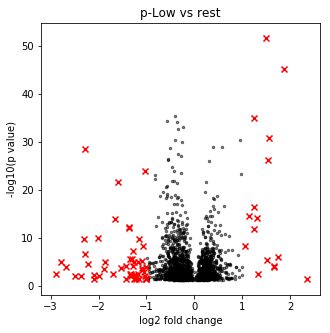

In [31]:
DE_rest_individual(adata_parental, 'status', 'p-Low', 'Met-Like_parental')

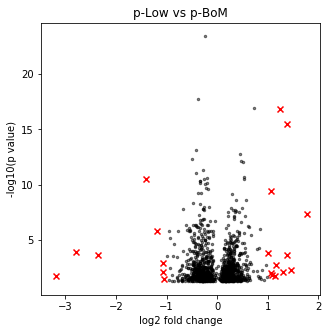

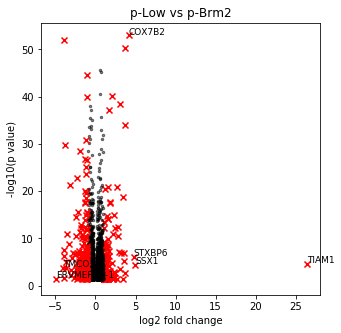

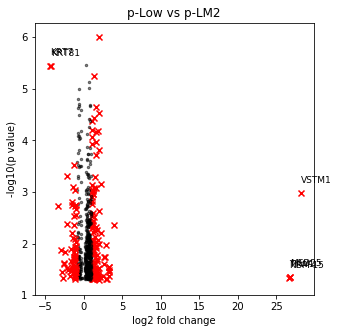

In [32]:
DE_pairwise(adata_parental, 'status','p-Low', 'p-BoM')
DE_pairwise(adata_parental, 'status','p-Low', 'p-Brm2')
DE_pairwise(adata_parental, 'status','p-Low', 'p-LM2')

In [26]:
adata.obs['new'] = ''
for row in range(len(adata.obs['sorted_leiden'])):
    if adata.obs['sorted_leiden'][row] in (['14','15','16']):
        adata.obs['new'][row] = 'proxy_parental'
    else:
        adata.obs['new'][row] = adata.obs['sorted_leiden'][row]

/wynton/home/pollard/egilbertson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/wynton/home/pollard/egilbertson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [27]:
adata.obs

,SampleType,quality,n_genes,percent_mito,n_counts,logqual,status,leiden,sorted_leiden,new
AAACCCAAGGTGAGAA,TGL,inf,3986,0.078526,14785.0,inf,p-Low,13,11,11
AAACCCACACCAATTG,BoM,inf,4704,0.041420,19556.0,inf,BoM,4,1,1
AAACCCACAGGGAATC,TGL,inf,5150,0.061617,27168.0,inf,p-Low,2,12,12
AAACCCAGTGTTGCCG,TGL,63.0,6015,0.066625,35212.0,1.799341,p-Low,0,8,8
AAACCCAGTTTGATCG,TGL,inf,4912,0.064147,21404.0,inf,p-Low,10,9,9
...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCAGTATACC,BoM,35.0,6313,0.058383,38727.0,1.544068,BoM,9,6,6
TTTGTTGCAGTTGAAA,TGL,inf,4972,0.076738,22414.0,inf,p-Low,0,8,8
TTTGTTGCATAACAGA,BoM,inf,4792,0.065015,23041.0,inf,BoM,7,5,5
TTTGTTGGTCGTGGTC,Brm2,inf,4357,0.075987,20543.0,inf,Brm2,8,13,13


... storing 'new' as categorical


0
1
2
3
4
5
6
7
8
9
10
11
12
13


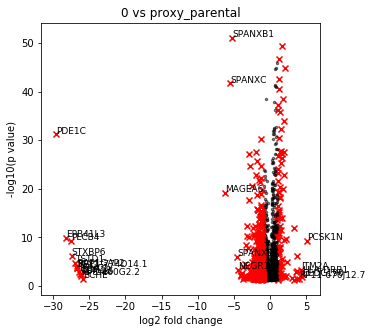

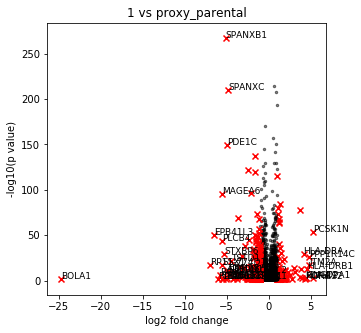

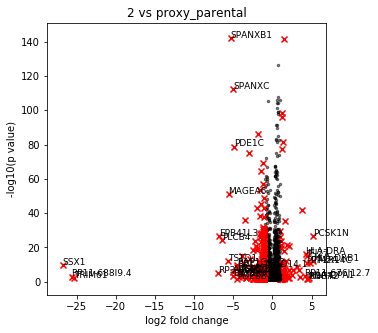

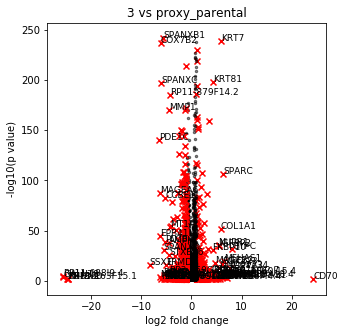

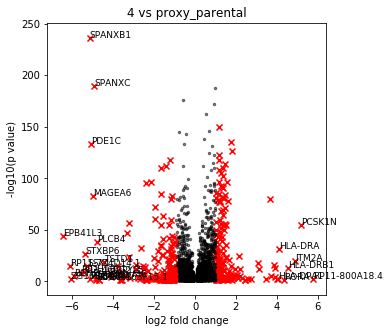

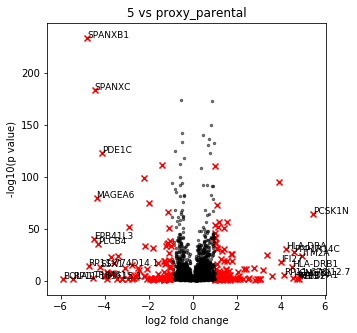

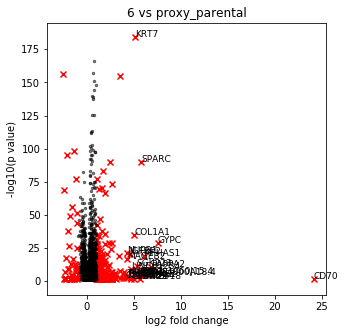

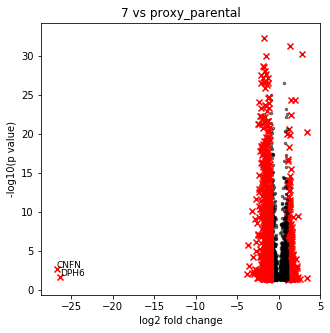

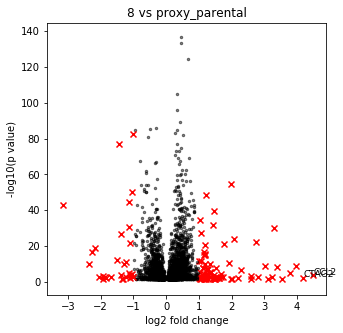

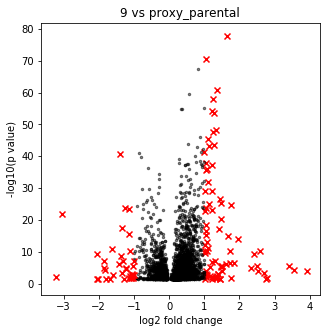

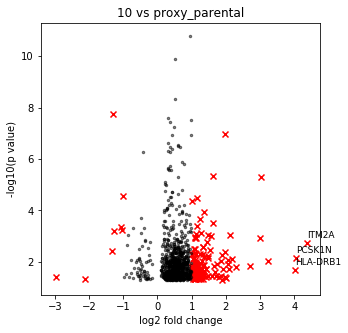

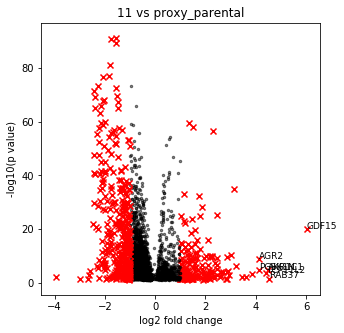

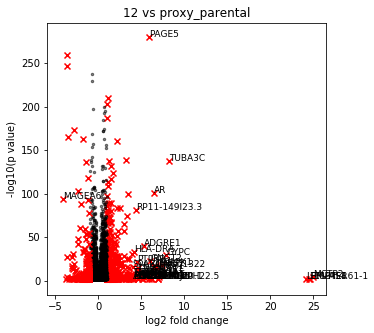

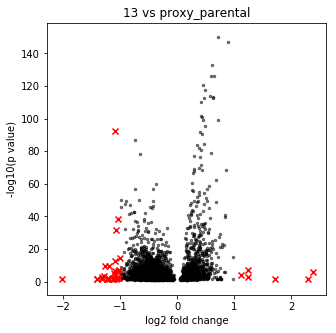

In [30]:
for a in range(0,14):
    print(a)
    DE_pairwise(adata, 'new',str(a), 'proxy_parental' )

In [32]:
s = ['SampleType','status','sorted_leiden']
scott = adata.obs[s]

In [33]:
scott

,SampleType,status,sorted_leiden
AAACCCAAGGTGAGAA,TGL,p-Low,11
AAACCCACACCAATTG,BoM,BoM,1
AAACCCACAGGGAATC,TGL,p-Low,12
AAACCCAGTGTTGCCG,TGL,p-Low,8
AAACCCAGTTTGATCG,TGL,p-Low,9
...,...,...,...
TTTGTTGCAGTATACC,BoM,BoM,6
TTTGTTGCAGTTGAAA,TGL,p-Low,8
TTTGTTGCATAACAGA,BoM,BoM,5
TTTGTTGGTCGTGGTC,Brm2,Brm2,13


In [34]:
scott.to_csv('MDA_celltype_classification.csv')